# I.I.D. firing rates from exponential
Quesa parte contieni conti e simulazioni aggiuntive a quelle dell'articolo di Touboul.

Questo risultato è derivato in *Faggin* in cui si vede che la prob di avere un avalanche con un tempo maggiore di $t=n dt$ è un  esponenziale dipendente dalle carateristiche della probabilità da cui è estratto il firing rate e dal $dt$ usato. 

Rispetto al lavoro di Faggin io faccio la scelta di usare un $\Delta t$ per misurare le mie falanche uguale a $\Delta t = dt$, offero il time step con cui simulo. Questo ha ovviamente ripercussioni sulla mia analisi perché influensa la capacità di vedere avalanches. Se avessi scelto $\Delta t = 5 dt$ avrei sicuramente ignorato valanghe più piccole e quelle più grandi che avrei osservato, sarebbero state più piccole (spero sia comprensibile, ma fai un disegnino di valanghe e prova a cambiare il binning con cui fai il sample e noterai).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

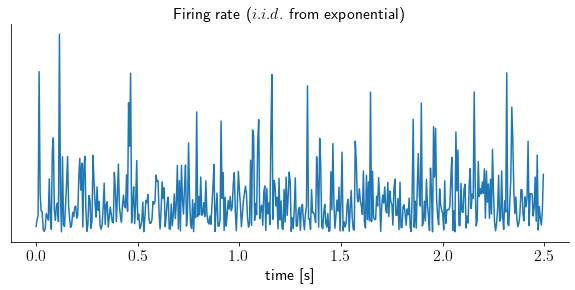

In [10]:
# Parameters for the simulation
T = 4000 # time of sim in s
dt = 0.005 # time step 
N_neurons = 100
n = int(T/dt) # total time steps
t = np.linspace(0., T, n) # vector of times.

#-----------------
# I.I.D
# generate i.i.d. firing rates from
# gamma * exp (- gamma* firing_rate)

# inverse transform sampling method:
# CDF : 1 - exp(-gamma* firing_rate) = y
# hence
# choosing y from Unif(0,1)
# firing_rate = - ln(1-y)/gamma = - ln y / gamma
# where the last equation is due to the range of y

# properties of the distribution:
# <firing_rate> = 1 / gamma
#-----------------

gamma = 0.5 # Faggian thesis
rho = np.zeros(n)
np.random.seed(710) # for reproducible firing rates
for i in range(n):
    rho[i] = - np.log( np.random.random() ) / gamma

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.set_title("Firing rate ($i.i.d.$ from exponential)")
ax.set_xlabel("time [s]")
ax.axes.get_yaxis().set_visible(False)
ax.plot(t[0:500],rho[0:500])

In [11]:
# Spike train generation

S_shape_ = np.zeros(n)

max_rho = np.max(rho)

for neuron in range(N_neurons):
    
    # Algo 6 from Higham's paper
    time = 0 # starting time for the homogeneous process [bins]
    while time < n:
        u = np.random.random()
        interspike_t = int( (- np.log(u)/max_rho)/ dt ) 
        time += interspike_t
        #print(time)
        
        if time > n-1: break
        
        v = np.random.random()
        if v <= rho[time]/max_rho :
            S_shape_[time] += 1

In [12]:
where_spikes = np.where(S_shape_ != 0)
interspike_time = (where_spikes - np.roll(where_spikes,1))
interspike_time = np.delete(interspike_time,0) # remouve the first element

mean_interspike_time = np.sum(interspike_time)/len(interspike_time)
mean_interspike_time = int(mean_interspike_time)
print("Mean interspike time [dt units]:", mean_interspike_time)


# Now I modify the S_shape_ in order to applay the ney binning

rest = int(n%mean_interspike_time)
if rest == 0:
    n_reduced = int(n/mean_interspike_time)
else:
    n_reduced = int((n-rest)/mean_interspike_time)
    
S_shape = np.zeros(n_reduced)
delta = mean_interspike_time
# In this procedure, I'm ignoring "rest" numeber of point in S_shape_, not important
for i in range(0, n-rest, mean_interspike_time):
    
    j = int(i/mean_interspike_time)
    S_shape[j] = S_shape_[i:i+delta].sum()
    

Mean interspike time [dt units]: 1


In [13]:
# Avalanche finder
t_in = [] # timestep in which avalanche starts
t_fin = [] # " ends
avalanche = False

for timestep in range(n_reduced):
    
    if S_shape[timestep] != 0:
        if avalanche == False:
            t_in.append(timestep)
            avalanche = True
    if S_shape[timestep] == 0 and avalanche == True:
        t_fin.append( timestep ) 
        avalanche = False

# Erase the last avalanche if the last element of S_shape is != 0
if len(t_in) != len(t_fin):
    t_in.pop(-1)
    
# convert them into arrays for efficiency porpouses
t_in = np.array(t_in)
t_fin = np.array(t_fin)

In [6]:
# Libreries
import sys, os
import pandas as pd

%load_ext autoreload
%autoreload 2
import matplotlib.cm as cm # color map
cmap = cm.tab10

## custom packages
src_dir = os.path.join(os.pardir,'testing-statistical-laws-in-complex-systems/src')
sys.path[0] = src_dir

from data_io_ts import *
from stats import xdata_to_xnx, x_autocorr_sm_ext
from powerlaw_fit import *

from modules_plotting import * # import setup for figure layout (see src/modules_plotting.py to customize)

In [14]:
# Duration distribution
duration = np.array(t_fin - t_in)  # number of bins
duration

array([2, 2, 3, ..., 1, 1, 3])

In [15]:
# Fit

from scipy.stats import linregress

x, nx = xdata_to_xnx(duration, norm=False,xmin=1,xmax=None)

x = np.delete(x,-1) # remouve a bad point
nx = np.delete(nx,-1)


nx_log = np.log10(nx)

slope, intercept, r_value, p_value, std_err = linregress(x, nx_log)

print('r value:', r_value)
print('intercept:', intercept)
print('slope:', slope)
print('Std for the slope:', std_err)

# Theoretic values
print('\n')
slope_theo = np.log10( N_neurons*dt/(gamma + N_neurons*dt) )
intercept_theo = 2*np.log10( gamma/(gamma + N_neurons*dt) )
print('Theoretical slope:', slope_theo)
print('Theoretical intercept:', intercept_theo)

r value: -0.9970593237562546
intercept: 5.232683380893418
slope: -0.2822740898678732
Std for the slope: 0.00560174682635341


Theoretical slope: -0.3010299956639812
Theoretical intercept: -0.6020599913279624


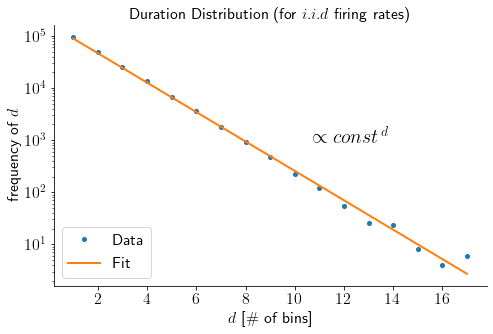

In [16]:
### Plot
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

## Plot the distribution
x_ = x
y_ = nx
c_ = cmap(0)
ax.plot(x_,y_,marker='o',ms=4,lw=0,c = c_,label = 'Data')

## Plot the fit
c_ = cmap(1)
x_ = x
y_ = [ (10**intercept)*(10**slope)**t  for t in x]
# here intercept and x range are modified for visual purposes
plt.plot(x_,y_,lw=2,c=c_, label = 'Fit')


## Layout stuff
ax.legend(loc='lower left')

#ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim(1,10**3)
#ax.set_ylim(5*10**(3),7*10**(-1))

ax.set_xlabel(r'$d$ [$\#$ of bins]')#,labelpad=0)
ax.set_ylabel(r'frequency of $d$')
ax.set_title('Duration Distribution (for $i.i.d$ firing rates)')

x_annot_formula = 0.6
y_annot_formula = 0.55
ax.annotate(r'$\propto const^{\, d}$',xy=(x_annot_formula,y_annot_formula),xycoords = 'axes fraction',size=20)

plt.savefig('duration_iid', format='pdf')


**NOTA**: la costante è minore di uno, senno non sarebbe  stato decrescente la curva